In [ ]:
%matplotlib widget

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Загружаем данные
file_path = "../npz/BTCUSD_1T.npz"
data = np.load(file_path, allow_pickle=True)
if 'data' in data:
    raw_data = data['data']
else:
    raise ValueError("Файл не содержит ключа 'data'")
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
df = pd.DataFrame(raw_data, columns=columns)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# При необходимости можно ограничить число точек:
# df = df.iloc[-100000:]


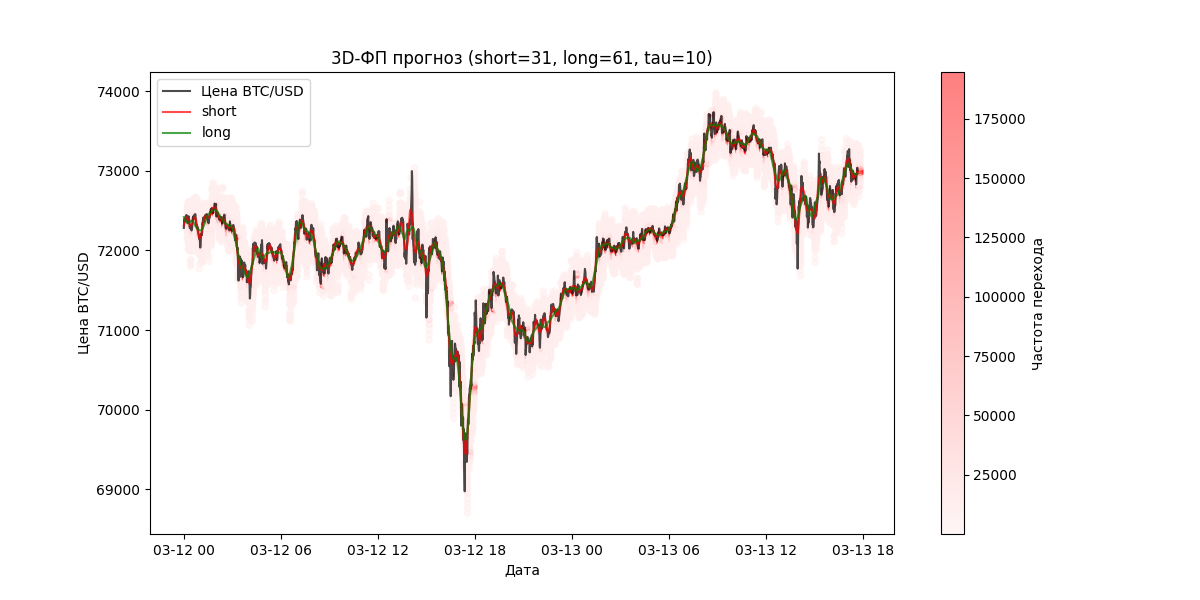

In [59]:

########################################################################
# Вспомогательная функция для перевода (x, y, z) в индексы сетки с использованием объекта grid_size
def to_grid_3d(xx, yy, zz, bounds, grid_size):
    """
    Преобразует координаты (xx, yy, zz) в индексы сетки.
    
    :param xx, yy, zz: координаты точки.
    :param bounds: кортеж (x_min, x_max, y_min, y_max, z_min, z_max).
    :param grid_size: словарь с ключами 'x', 'y', 'z' для размеров сетки.
    :return: кортеж (i_x, i_y, i_z) – индексы точки в сетке.
    """
    (x_min, x_max, y_min, y_max, z_min, z_max) = bounds
    i_x = int((xx - x_min) / (x_max - x_min) * (grid_size['x'] - 1))
    i_y = int((yy - y_min) / (y_max - y_min) * (grid_size['y'] - 1))
    i_z = int((zz - z_min) / (z_max - z_min) * (grid_size['z'] - 1))
    return (i_x, i_y, i_z)

########################################################################
# Функция построения 3D-кэша фазового пространства с отдельными размерами сетки (через объект grid_size)
def build_phase_space_grid_3d(df, window_short, window_long, tau, grid_size):
    """
    Разбивает фазовое пространство (x, y, z) на 3D-сетку и заполняет кэш переходов.
    Здесь:
      x = price_diff (0-я производная сглаженного относительного изменения цены)
      y = первая производная (относительное изменение скорости)
      z = вторая производная (ускорение изменения относительного изменения)
    
    :param df: DataFrame с ценами.
    :param window_short: короткое окно сглаживания.
    :param window_long: длинное окно сглаживания.
    :param tau: шаг прогноза (в баров).
    :param grid_size: словарь с размерами сетки, например {'x':50, 'y':50, 'z':50}.
    :return: (cache, bounds), где
             cache = { (i_x, i_y, i_z) -> { future_x: count } }
             bounds = (x_min, x_max, y_min, y_max, z_min, z_max)
    """
    polyorder = 3

    # Сглаживаем цену
    smoothed_short = savgol_filter(df['close'].values, window_short, polyorder)
    smoothed_long  = savgol_filter(df['close'].values, window_long, polyorder)
    
    # Относительное изменение (в процентах)
    tmp = (smoothed_short - smoothed_long) / smoothed_long

    # Вычисляем три координаты: 
    # x = базовый сигнал (разность),
    # y = первая производная,
    # z = вторая производная.
    x = savgol_filter(tmp, window_short, polyorder, deriv=0)
    y = savgol_filter(tmp, window_short, polyorder, deriv=1)
    z = savgol_filter(tmp, window_short, polyorder, deriv=2)
    
    # Границы фазового пространства
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    z_min, z_max = np.min(z), np.max(z)
    bounds = (x_min, x_max, y_min, y_max, z_min, z_max)
    
    cache = {}  # { (i_x, i_y, i_z) -> { future_x: count } }
    n = len(x) - tau
    for t in range(n):
        cell_now = to_grid_3d(x[t], y[t], z[t], bounds, grid_size)
        cell_future = to_grid_3d(x[t+tau], y[t+tau], z[t+tau], bounds, grid_size)
        future_x = cell_future[0]  # Используем только x-компоненту будущей ячейки
        if cell_now not in cache:
            cache[cell_now] = {}
        if future_x not in cache[cell_now]:
            cache[cell_now][future_x] = 0
        cache[cell_now][future_x] += 1
    return cache, bounds

########################################################################
# Функция визуализации прогноза с использованием 3D-кэша (новый формат кеша)
def plot_price_forecast_with_heatmap_3d(df, cache, bounds, window_short, window_long, tau, num_points, grid_size):
    """
    Строит график цен (для первых num_points точек) и наносит прогноз в виде точек,
    где цвет отражает частоту перехода. Для обратного прогнозирования используется только x-компонента из 3D-кэша.
    
    :param df: DataFrame с ценами (тестовая выборка).
    :param cache: 3D-кэш переходов, где значения future сохранены как целое число (x-компонента).
    :param bounds: (x_min, x_max, y_min, y_max, z_min, z_max) – границы фазового пространства.
    :param window_short: короткое окно сглаживания.
    :param window_long: длинное окно сглаживания.
    :param tau: шаг прогноза.
    :param num_points: число точек для отображения.
    :param grid_size: словарь с размерами сетки, например {'x':200, 'y':100, 'z':10}.
    """
    polyorder = 3
    (x_min, x_max, y_min, y_max, z_min, z_max) = bounds

    # Сглаживаем цену
    smoothed_short = savgol_filter(df['close'].values, window_short, polyorder)
    smoothed_long  = savgol_filter(df['close'].values, window_long, polyorder)
    tmp = (smoothed_short - smoothed_long) / smoothed_long

    # Вычисляем x, y, z
    x = savgol_filter(tmp, window_short, polyorder, deriv=0)
    y = savgol_filter(tmp, window_short, polyorder, deriv=1)
    z = savgol_filter(tmp, window_short, polyorder, deriv=2)

    # Используем ту же функцию to_grid_3d для преобразования
    def to_grid(xx, yy, zz):
        return to_grid_3d(xx, yy, zz, bounds, grid_size)

    future_points = []
    future_counts = []
    N = len(x)
    for t in range(min(num_points, N - tau)):
        cell_now = to_grid(x[t], y[t], z[t])
        if cell_now in cache:
            for future_x, count in cache[cell_now].items():
                future_index = t + tau
                if future_index < N:
                    # Обратное преобразование: переводим future_x обратно в значение x
                    future_price_diff = x_min + (future_x / (grid_size['x'] - 1)) * (x_max - x_min)
                    # Грубая гипотеза для прогноза: будущая цена = future_price_diff * smoothed_long[t] + df['close'].iloc[t]
                    future_price = future_price_diff * smoothed_long[t] + df['close'].iloc[t]
                    future_time = df.index[future_index]
                    future_points.append((future_time, future_price))
                    future_counts.append(count)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index[:num_points], df['close'].iloc[:num_points], label="Цена BTC/USD", color='black', alpha=0.7)
    ax.plot(df.index[:num_points], smoothed_short[:num_points], label="short", color='red', alpha=0.7)
    ax.plot(df.index[:num_points], smoothed_long[:num_points], label="long", color='green', alpha=0.7)
    if future_points:
        future_times, future_prices = zip(*future_points)
        from matplotlib.colors import LinearSegmentedColormap
        # Создаём одноцветный красный градиент от светлого к насыщенному
        red_gradient = LinearSegmentedColormap.from_list("red_gradient", ["#FFEEEE", "#FF0000"])
        scatter = ax.scatter(future_times, future_prices, c=future_counts, cmap=red_gradient, alpha=0.5, s=19)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label("Частота перехода")
    ax.set_title(f"3D-ФП прогноз (short={window_short}, long={window_long}, tau={tau})")
    ax.set_xlabel("Дата")
    ax.set_ylabel("Цена BTC/USD")
    ax.legend()
    plt.show()

# Пример: разделим данные на train/test (80/20)
N = len(df)
train_size = int(0.8 * N)
train_df = df.iloc[:train_size]
test_df  = df.iloc[train_size:]

tau = 10
window_short = 31
window_long  = 61

# Определяем размеры сетки через объект
grid_size = {'x': 50, 'y': 20, 'z': 10}

# Построение 3D-кэша на обучающих данных
cache_3d, bounds_3d = build_phase_space_grid_3d(train_df, window_short, window_long, tau, grid_size)

# Визуализируем прогноз на тестовой выборке (например, для первых 500 точек)
plot_price_forecast_with_heatmap_3d(test_df, cache_3d, bounds_3d, window_short, window_long, tau, num_points=2500, grid_size=grid_size)
